# Read Violence Project Database
## Context
A previous version of this project assumed that the user would open the database in Excel first to extract selected data to a separate CSV file that can be used from a notebook. In this version, we improve the import process by working directly with the XLSX file provided by the Violence Project. This code is compatible with the database version 8 (updated in January 2024.)

## Data Source
Peterson, J., & Densley, J. (2023). *The Violence Project database of mass shootings in the United States (Version 8)*. https://www.theviolenceproject.org

The database is provided under license by The Violence Project and is therefore not made available here.

## Tasks performed
In this notebook, the following steps are taken as part of data extraction and preliminary analysis:
1. The full database is extracted from the Violence Project Excel sheet
2. Some data cleaning low-hanging fruits are handled: deletion of hidden characters and simple data type fixes
3. The information related to the shooters only is extracted from the full database
4. The encoded data are replaced by explicit values
5. Missing values in the shooters data are handled
6. Preliminary conclusions are drawn from the data

## Import and function definitions

### Import dependencies

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from pathlib import Path

In [3]:
# Local modules
import codebook
from codebook import replace_code_by_value

In [4]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

### Functions for data cleaning

In [5]:
def clean_column_names(df, verbose=False):
    # Find column names with non-conventional characters
    item = '\xa0'

    problems = []

    for c in df.columns:
        if item in c:
            problems.append(c)

    # Remove problematic characters from column names
    problems_fixed = [p.replace('\xa0','') for p in problems]
    
    if verbose:
        # Print problematic and fixed columns
        print(f"Columns: {problems}")
        print(f"Replaced by: {problems_fixed}")

    # Rename problematic columns
    for i in range(len(problems)):
        df = df.rename(columns={problems[i]: problems_fixed[i]})

    return df

In [6]:
def fix_incorrect_strings(df, col):

    for i in range(len(df[col])):
        try: 
            datetime_obj = dt.strptime(df[col][i], '%Y-%m-%d %H:%M:%S')
            df[col][i] = (str(datetime_obj.month) + ', ' + str(datetime_obj.day))
        except:
            pass

    return df

### Functions for data transformation

In [7]:
def apply_codebook_values(df):
    replace_code_by_value(df, 'Gender', codebook.codes_shooter_background_gender)
    replace_code_by_value(df, 'Race', codebook.codes_shooter_background_race)
    replace_code_by_value(df, 'Immigrant', codebook.codes_shooter_background_immigrant)
    replace_code_by_value(df, 'Education', codebook.codes_shooter_background_education)
    replace_code_by_value(df, 'Relationship Status', codebook.codes_shooter_background_relationship)
    replace_code_by_value(df, 'Employment Status', codebook.codes_shooter_background_employstatus)
    replace_code_by_value(df, 'Employment Type', codebook.codes_shooter_background_employtype)
    replace_code_by_value(df, 'Military Service', codebook.codes_shooter_background_milservice)
    replace_code_by_value(df, 'Highest Level of Justice System Involvement', codebook.codes_shooter_crime_justice)
    replace_code_by_value(df, 'Parental Divorce / Separation', codebook.codes_shooter_trauma_divorce)
    replace_code_by_value(df, 'Childhood SES', codebook.codes_shooter_trauma_ses)
    replace_code_by_value(df, 'Mental Illness', codebook.codes_shooter_health_illness)
    replace_code_by_value(df, 'Known Family Mental Health History', codebook.codes_shooter_health_family)
    replace_code_by_value(df, 'Autism Spectrum', codebook.codes_shooter_health_autism)
    replace_code_by_value(df, 'Health Issues', codebook.codes_shooter_health_issues)

    return df

In [8]:
def simplify_fields(df):

    # Race, replace less common races
    specific_races = ['White', 'Black', 'Latinx']
    mask = ~(df['Race'].isna()) & (~df['Race'].isin(specific_races))
    df.loc[mask, 'Race'] = 'Other'

    # Employment status, replace empty field by 'Unknown'
    df.loc[df['Employment Status'] == ' ', 'Employment Status'] = 'Unknown'

    # Military service: if training not completed -> No
    df.loc[df['Military Service'] == 'Joined but did not make it through training', 'Military Service'] = 'No'

    # Change Highest Level of Justice System Involvement to Arrested or Not Arrested
    df = df.rename(columns={'Highest Level of Justice System Involvement': 'Arrested'})
    df.loc[df['Arrested'] == 'Arrested', 'Arrested'] = 'Yes'
    df.loc[df['Arrested'] == 'Charged', 'Arrested'] = 'Yes'
    df.loc[df['Arrested'] == 'Convicted', 'Arrested'] = 'Yes'
    df.loc[df['Arrested'] == 'NA', 'Arrested'] = 'No'
    df.loc[df['Arrested'] == 'Suspected', 'Arrested'] = 'No'

    # Mental illness
    df.loc[df['Mental Illness'] == 'Indication of psychiatric disorder but no diagnosis', 'Mental Illness'] = 'No evidence'
    df.loc[df['Mental Illness'] != 'No evidence', 'Mental Illness'] = 'Yes'

    # Parent mental illness
    df.loc[df['Known Family Mental Health History'] != 'No evidence', 'Known Family Mental Health History'] = 'Yes'

    # Autism
    df.loc[df['Autism Spectrum'] == 'Diagnosed or extremely likely', 'Autism Spectrum'] = 'Yes'

    return df

### Functions for data exploration

In [9]:
def database_info(df):
    print(f"Number of rows: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")

    null_values = (df.isna()*1).sum().sum()
    non_null_values = (~df.isna()*1).sum().sum()
    total_values = null_values+non_null_values

    print(f"Number of values: {total_values}")
    print(f"Number of missing values: {null_values}")
    print(f"Missing values ratio: {100*null_values/total_values:.1f}%")

In [10]:
def summary_stats(series):
    summary_df = (pd.DataFrame(series.value_counts(dropna=False).sort_index())
                .reset_index()
                .rename(columns={'index': series.name, series.name: 'Count'})
                ).sort_values('Count', ascending=False)

    missing_tag = '**Missing'

    summary_df.loc[summary_df[series.name].isna(), series.name] = missing_tag

    summary_df['Percent'] = round(100*summary_df['Count'] / summary_df['Count'].sum(), 2)

    return summary_df

### Functions for data visualisation

In [11]:
# Define plot parameters
main_color = '#969696'
highlight_color = '#04bfb3'
default_figsize = (10,6)

In [12]:
def display_pie(x, labels, title):
    # Create a new figure
    fig, ax = plt.subplots(figsize=default_figsize)

    # Remove top and right borders
    sns.despine()

    ax.pie(
        x=x,
        labels=labels,
        colors=[main_color, highlight_color],
        autopct='%.1f%%',
        pctdistance=.85
    )

    hole = plt.Circle((0,0), 0.7, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(hole)

    ax.set_title(title)

    plt.show()

In [13]:
def display_feature_hist(summary_df):

    series_name = summary_df.iloc[:,0].name

    col_2 = '#787878'
    col_1 = main_color

    summary_df = summary_df.sort_values('Count')

    colors = [col_1 if c != '**Missing' else col_2 for c in summary_df[series_name].astype('str')]

    fix, ax = plt.subplots(figsize=default_figsize)

    sns.despine()

    ax.barh(y=summary_df[series_name].astype('str'), width=summary_df['Count'], color=colors)
    ax.set_title(series_name)

    plt.show()

## Import data

### Read from XLSX file

In [14]:
database = pd.read_excel("The Violence Project Mass Shooter Database - Version 8 (January 2024) .xlsx", sheet_name='Full Database', dtype={'Mental Illness': str}, parse_dates=False)

### Preliminary cleaning

In [15]:
# Drop first row (does not contain data) and reset index
database = database.drop(0, axis=0).reset_index()

# Remove non-conventional characters and trailing spaces from column names
database = clean_column_names(database)

# Fix strings that are classified as dates by Excel
database = fix_incorrect_strings(database, 'Mental Illness')

### Display DataFrame information

In [16]:
database_info(database)

Number of rows: 197
Number of columns: 158
Number of values: 31126
Number of missing values: 3072
Missing values ratio: 9.9%


## Extract shooter information

### Isolate features important for project

In [17]:
shooter_columns = [
        'Age',
        'Gender',
        'Race',
        'Immigrant',
        'Education',
        'Relationship Status',
        'Employment Status',
        'Employment Type',
        'Military Service',
        'Highest Level of Justice System Involvement',
        'Parental Divorce / Separation',
        'Childhood SES',
        'Mental Illness',
        'Known Family Mental Health History',
        'Autism Spectrum',
        'Health Issues'
        ]

In [18]:
# Extract the shooter information from the complete database
shooters_df = database[shooter_columns]

# Convert Age column to numeric
shooters_df['Age'] = shooters_df['Age'].astype('int8')

# Replace the numeric codes by explicit values
shooters_df = apply_codebook_values(shooters_df)

# Simplify values in fields
shooters_df = simplify_fields(shooters_df)

# Display information
database_info(shooters_df)

Number of rows: 197
Number of columns: 16
Number of values: 3152
Number of missing values: 177
Missing values ratio: 5.6%


## Shooter Data Exploration

### Age
The age distribution is shown below. There are no missing data in the dataset.

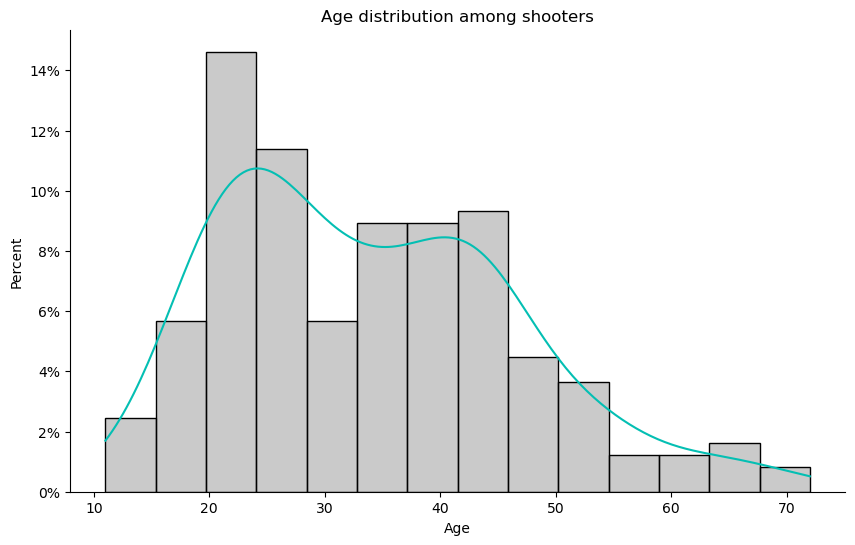

In [19]:
# Create a new figure
fig, ax = plt.subplots(figsize=default_figsize)

# Remove top and right borders
sns.despine()

# Plot histogram with KDE line
sns.histplot(
    shooters_df,
    x='Age',
    bins=14,
    kde=True,
    stat='percent',
    color=main_color
)

# Changle colour of KDE line
ax.lines[0].set_color(highlight_color)

# Change yticks to show % sign
yticks = list(range(0,16,2))
ymarks = [str(t)+'%' for t in yticks]

ax.set_xlabel('Age')
ax.set_yticklabels(ymarks)

# Add a title
ax.set_title('Age distribution among shooters')

# Show figure
plt.show()

### Gender
The vast majority of shooters are male.

In [20]:
series = shooters_df['Gender']
summary_df = summary_stats(series)
summary_df

,Gender,Count,Percent
1,Yes,192,97.46
0,No,5,2.54


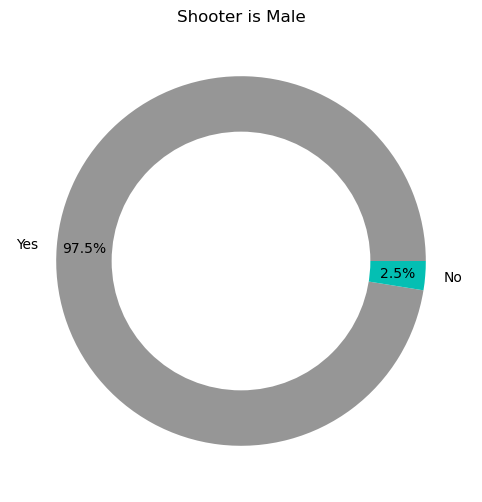

In [21]:
display_pie(summary_df['Count'], summary_df['Gender'], 'Shooter is Male')

### Race
More than half of the shooters in the database are white, with black being the next most represented ethnicity. Several minorities with only a few individuals are grouped under 'Other'.

There are 8 missing values in the dataset. Given the small proportions of them, they are replaced by the mode ('White').

In [22]:
series = shooters_df['Race']
summary_df = summary_stats(series)
summary_df

,Race,Count,Percent
3,White,104,52.79
0,Black,41,20.81
2,Other,25,12.69
1,Latinx,19,9.64
4,**Missing,8,4.06


In [23]:
# Replace missing values by mode
series = shooters_df['Race']
shooters_df.loc[shooters_df['Race'].isna(), 'Race'] = series.mode().values[0]
summary_df = summary_stats(series)
summary_df

,Race,Count,Percent
3,White,112,56.85
0,Black,41,20.81
2,Other,25,12.69
1,Latinx,19,9.64


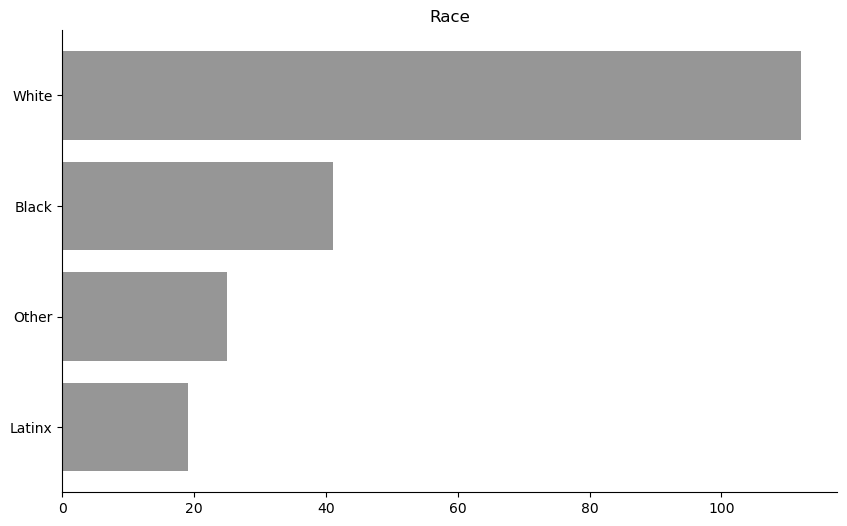

In [24]:
display_feature_hist(summary_df)

### Immigration status
There are only two status in the database: No (the individual was not an immigrant) or Yes No (the individual was an immigrant)

There are 2 missing values in the dataset. Given the small proportions of them, they are replaced by the mode ('No').

In [25]:
series = shooters_df['Immigrant']
summary_df = summary_stats(series)
summary_df

,Immigrant,Count,Percent
0,No,164,83.25
1,Yes,31,15.74
2,**Missing,2,1.02


In [26]:
# Replace missing values by mode
series = shooters_df['Immigrant']
shooters_df.loc[shooters_df['Immigrant'].isna(), 'Immigrant'] = series.mode().values[0]
summary_df = summary_stats(series)
summary_df

,Immigrant,Count,Percent
0,No,166,84.26
1,Yes,31,15.74


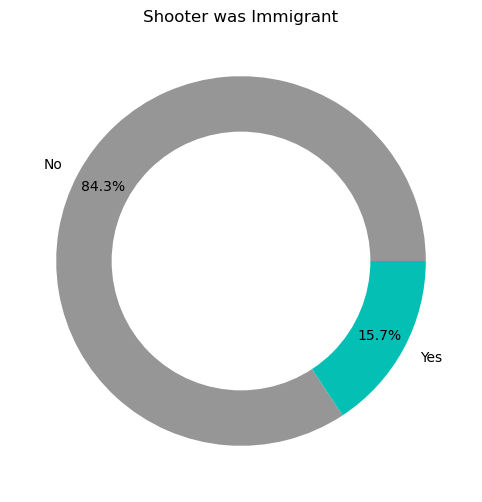

In [27]:
display_pie(summary_df['Count'], summary_df['Immigrant'], 'Shooter was Immigrant')

### Education
There are a large number of missing values for the maximum education level in the database. In order not to skew the data, a new category 'Unknown' is added to the variable.

In [28]:
series = shooters_df['Education']
summary_df = summary_stats(series)
summary_df

,Education,Count,Percent
4,Some college/trade school,54,27.41
5,**Missing,53,26.90
2,High school/GED,35,17.77
3,Less than high school,29,14.72
0,Bachelor's degree,14,7.11
1,Graduate school/advanced degree,12,6.09


In [29]:
shooters_df = shooters_df.fillna({'Education': 'Unknown'})
series = shooters_df['Education']
summary_df = summary_stats(series)
summary_df

,Education,Count,Percent
4,Some college/trade school,54,27.41
5,Unknown,53,26.90
2,High school/GED,35,17.77
3,Less than high school,29,14.72
0,Bachelor's degree,14,7.11
1,Graduate school/advanced degree,12,6.09


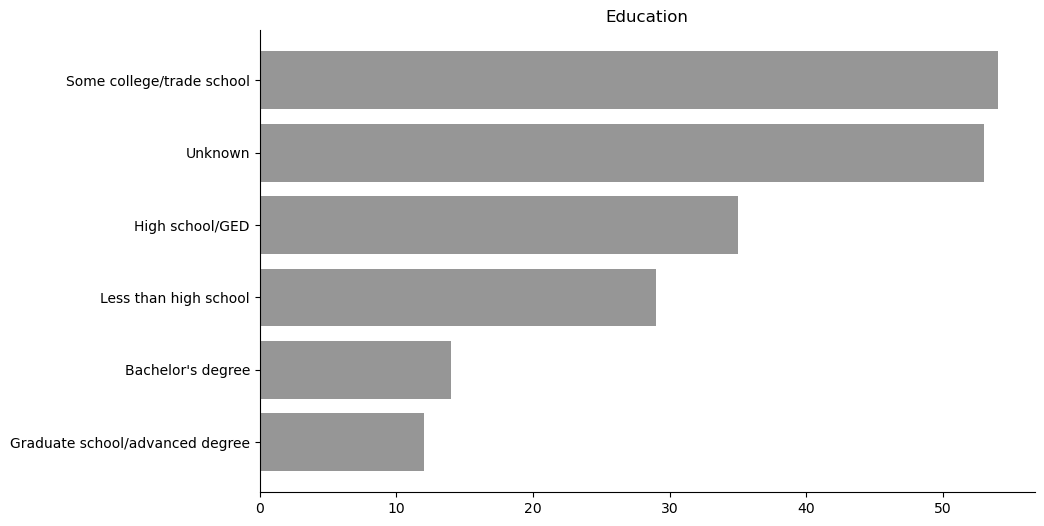

In [30]:
display_feature_hist(summary_df)

### Relationship Status
Due to the small number of missing data, this is replaced by the mode.

In [31]:
series = shooters_df['Relationship Status']
summary_df = summary_stats(series)
summary_df

,Relationship Status,Count,Percent
3,Single,99,50.25
1,Divorced/separated/widowed,32,16.24
2,Married,30,15.23
0,Boyfriend/girlfriend,28,14.21
4,**Missing,8,4.06


In [32]:
# Replace missing values by mode
series = shooters_df['Relationship Status']
shooters_df.loc[shooters_df['Relationship Status'].isna(), 'Relationship Status'] = series.mode().values[0]
summary_df = summary_stats(series)
summary_df

,Relationship Status,Count,Percent
3,Single,107,54.31
1,Divorced/separated/widowed,32,16.24
2,Married,30,15.23
0,Boyfriend/girlfriend,28,14.21


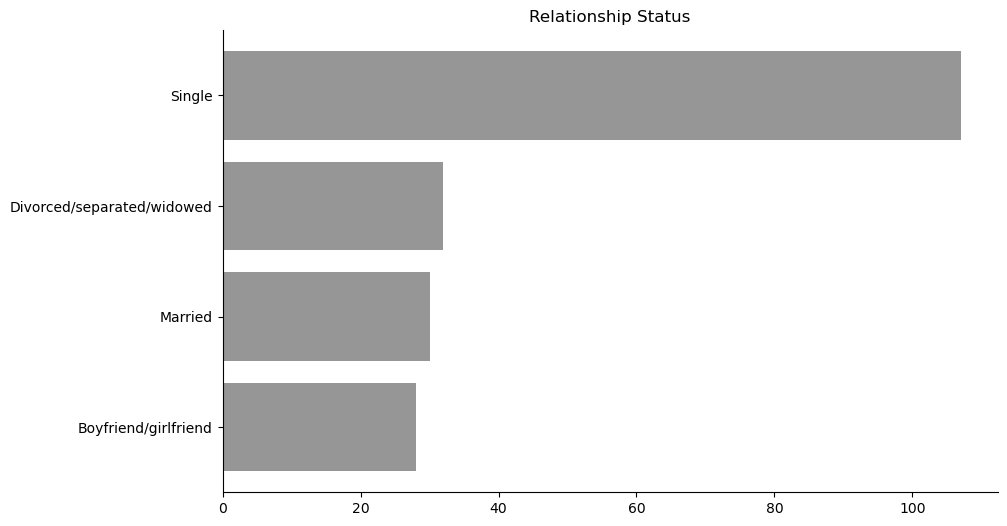

In [33]:
display_feature_hist(summary_df)

### Employment Status & Employment Type
Because they cover related information, the employment status and types are looked at together. 10 values out of 197 are missing for the employment status, plus 1 value that is specifically indicated as 'Unknown'. Because of their small proportion, these can be replaced by the mode ('Not working'.)

However, for the employment type, a total of 32 values are missing (9 where the status was missing and 23 with a status as 'Not working'.) Because the proportion is significant, the missing values are replaced by a new category: 'Unknown'. 

In [34]:
pd.DataFrame(shooters_df[['Employment Status','Employment Type']]
             .groupby('Employment Status', dropna=False)
             .value_counts(dropna=False)
             )

0
Employment Status Employment Type    
No                Blue collar      69
                  NaN              23
                  In between       11
                  White collar      9
Unknown           Blue collar       1
Yes               Blue collar      54
                  In between       12
                  White collar      8
NaN               NaN               9
                  Blue collar       1

In [35]:
series = shooters_df['Employment Status']
series.mode().values[0]

'No'

In [36]:
# Replace missing employment status by the mode
shooters_df.loc[shooters_df['Employment Status'].isna(), 'Employment Status'] = series.mode().values[0]
shooters_df.loc[shooters_df['Employment Status'] == 'Unknown', 'Employment Status'] = series.mode().values[0]

# Replace missing employment type by the 'Unknown'
shooters_df = shooters_df.fillna({'Employment Type': 'Unknown'})

pd.DataFrame(shooters_df[['Employment Status','Employment Type']]
             .groupby('Employment Status', dropna=False)
             .value_counts(dropna=False)
             )

0
Employment Status Employment Type    
No                Blue collar      71
                  Unknown          32
                  In between       11
                  White collar      9
Yes               Blue collar      54
                  In between       12
                  White collar      8

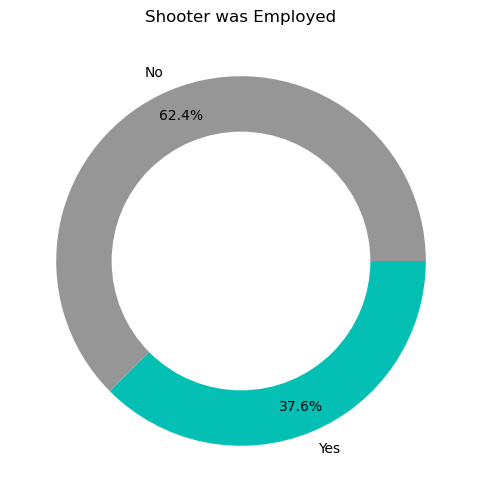

In [37]:
series = shooters_df['Employment Status']
summary_df = summary_stats(series)
display_pie(summary_df['Count'], summary_df['Employment Status'], 'Shooter was Employed')

In [38]:
series = shooters_df['Employment Type']
summary_df = summary_stats(series)
summary_df


,Employment Type,Count,Percent
0,Blue collar,125,63.45
2,Unknown,32,16.24
1,In between,23,11.68
3,White collar,17,8.63


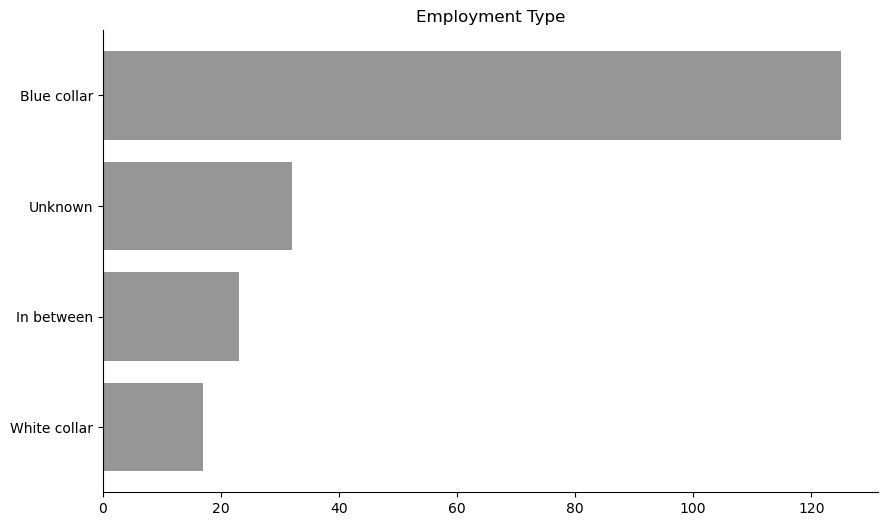

In [39]:
display_feature_hist(summary_df)

### Military Service
No missing values

In [40]:
series = shooters_df['Military Service']
summary_df = summary_stats(series)
summary_df

,Military Service,Count,Percent
0,No,151,76.65
1,Yes,46,23.35


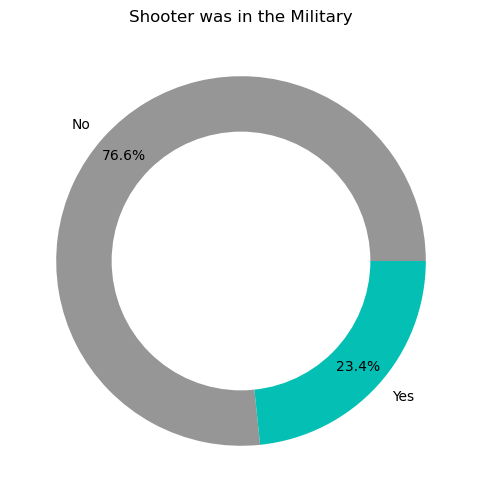

In [41]:
display_pie(summary_df['Count'], summary_df['Military Service'], 'Shooter was in the Military')

### Previous arrest
No missing values

In [42]:
series = shooters_df['Arrested']
summary_df = summary_stats(series)
summary_df

,Arrested,Count,Percent
1,Yes,107,54.31
0,No,90,45.69


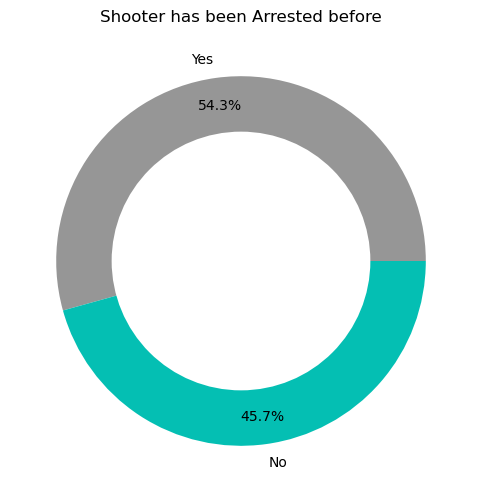

In [43]:
display_pie(summary_df['Count'], summary_df['Arrested'], 'Shooter has been Arrested before')

### Parental Divorce / Separation
Only 1 missing value -> replace by mode

In [44]:
series = shooters_df['Parental Divorce / Separation']
summary_df = summary_stats(series)
summary_df

,Parental Divorce / Separation,Count,Percent
0,No evidence,153,77.66
1,Yes,43,21.83
2,**Missing,1,0.51


In [45]:
# Replace missing values by mode
series = shooters_df['Parental Divorce / Separation']
shooters_df.loc[shooters_df['Parental Divorce / Separation'].isna(), 'Parental Divorce / Separation'] = series.mode().values[0]
summary_df = summary_stats(series)
summary_df

,Parental Divorce / Separation,Count,Percent
0,No evidence,154,78.17
1,Yes,43,21.83


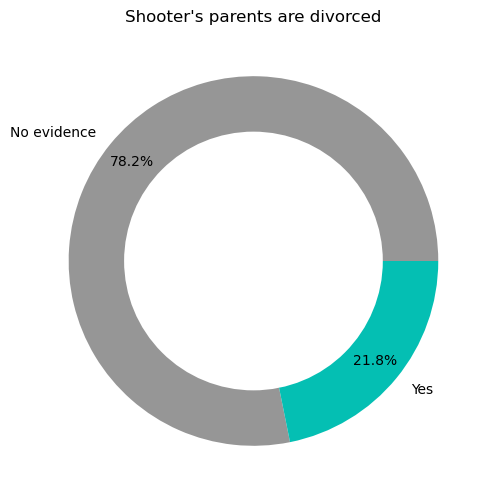

In [46]:
display_pie(summary_df['Count'], summary_df['Parental Divorce / Separation'], "Shooter's parents are divorced")

### Childhood SES
Large number of missing values -> replace with 'Unknown'

In [47]:
series = shooters_df['Childhood SES']
summary_df = summary_stats(series)
summary_df

,Childhood SES,Count,Percent
3,**Missing,63,31.98
1,Middle class,62,31.47
0,Lower class,53,26.90
2,Upper class,19,9.64


In [48]:
# Replace missing values
shooters_df = shooters_df.fillna({'Childhood SES': 'Unknown'})
series = shooters_df['Childhood SES']
summary_df = summary_stats(series)
summary_df

,Childhood SES,Count,Percent
2,Unknown,63,31.98
1,Middle class,62,31.47
0,Lower class,53,26.90
3,Upper class,19,9.64


In [49]:
series = shooters_df['Childhood SES']
summary_df = summary_stats(series)
summary_df

,Childhood SES,Count,Percent
2,Unknown,63,31.98
1,Middle class,62,31.47
0,Lower class,53,26.90
3,Upper class,19,9.64


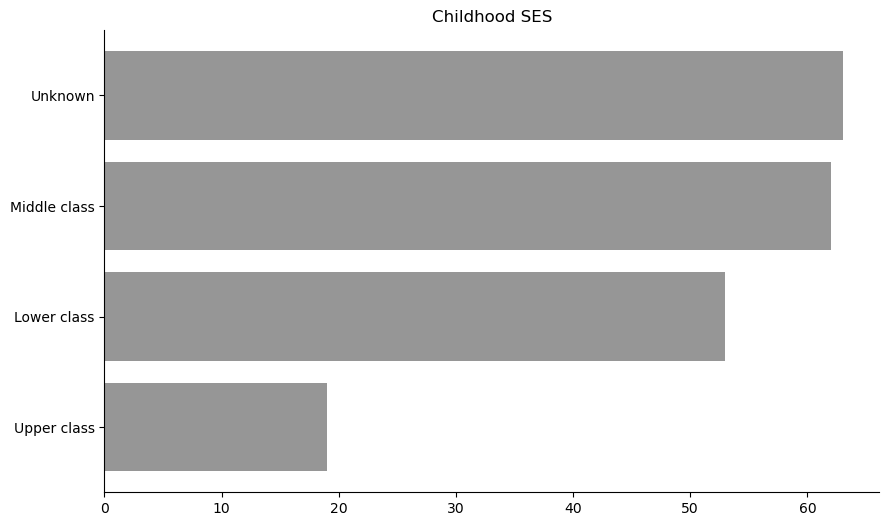

In [50]:
display_feature_hist(summary_df)

### Mental Illness
No missing values

In [51]:
series = shooters_df['Mental Illness']
summary_df = summary_stats(series)
summary_df

,Mental Illness,Count,Percent
0,No evidence,104,52.79
1,Yes,93,47.21


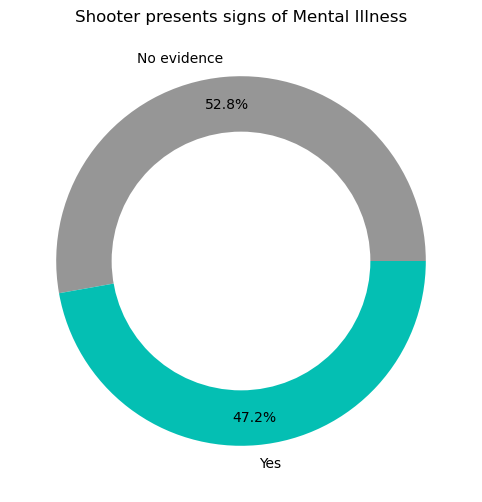

In [52]:
display_pie(summary_df['Count'], summary_df['Mental Illness'], "Shooter presents signs of Mental Illness")

### Known Family Mental Health History
No missing values

In [53]:
series = shooters_df['Known Family Mental Health History']
summary_df = summary_stats(series)
summary_df

,Known Family Mental Health History,Count,Percent
0,No evidence,165,83.76
1,Yes,32,16.24


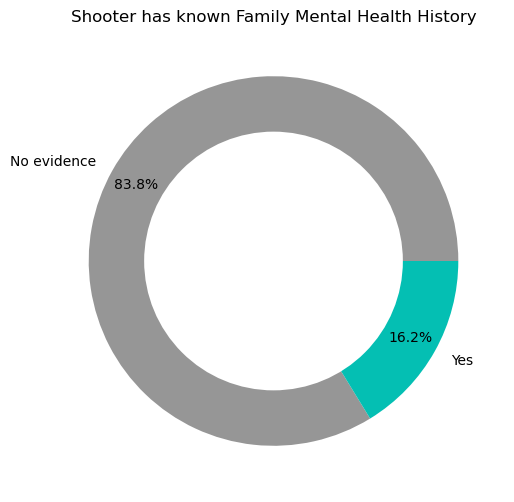

In [54]:
display_pie(summary_df['Count'], summary_df['Known Family Mental Health History'], "Shooter has known Family Mental Health History")

### Autism Spectrum
No missing values

In [55]:
series = shooters_df['Autism Spectrum']
summary_df = summary_stats(series)
summary_df

,Autism Spectrum,Count,Percent
0,No evidence,185,93.91
1,Yes,12,6.09


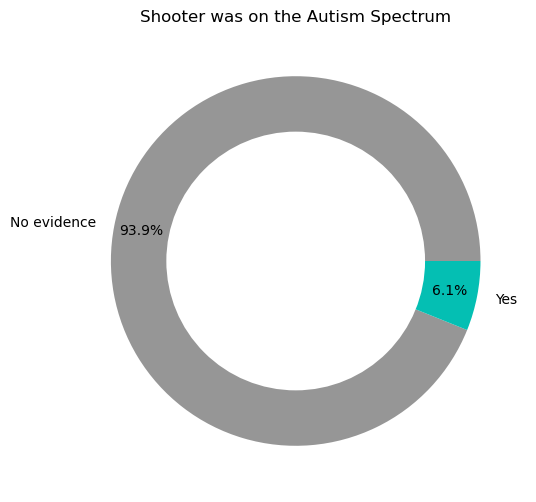

In [56]:
display_pie(summary_df['Count'], summary_df['Autism Spectrum'], "Shooter was on the Autism Spectrum")

### Health Issues
No missing values

In [57]:
series = shooters_df['Health Issues']
summary_df = summary_stats(series)
summary_df

,Health Issues,Count,Percent
0,No evidence,150,76.14
1,Yes,47,23.86


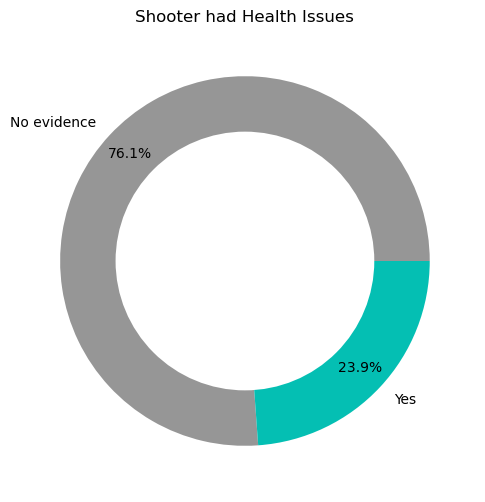

In [58]:
display_pie(summary_df['Count'], summary_df['Health Issues'], "Shooter had Health Issues")

## Save DataFrame as a CSV file

In [59]:
save_to_csv = True

if save_to_csv:
    shooters_df = shooters_df.rename(columns={
        'Gender': 'Male',
        'Relationship Status': 'RelStatus',
        'Employment Status': 'Employed',
        'Employment Type': 'Work',
        'Military Service': 'MilService',
        'Parental Divorce / Separation': 'ParentDivorce',
        'Childhood SES': 'SES',
        'Mental Illness': 'MentalIllness',
        'Known Family Mental Health History': 'MentalIllnessHistory',
        'Autism Spectrum': 'Autism',
        'Health Issues': 'HealthIssues'
    })

    # Add classification column
    shooters_df['Classification'] = 1

    # Save file for future analysis
    csv_out = Path('../Datasets/clean_data/clean_shooters_v8.csv')
    shooters_df.to_csv(csv_out, index=False)

    # Save file for model training
    csv_out = Path('../Model/model_blackbox_shooters_v8.csv')
    shooters_df.to_csv(csv_out, index=False)

    print('Files saved')
else:
    print('Files not saved. DataFrame columns are unchanged.')

Files saved
